# This notebook is a clustering study of Dublin neighborhoods

# Collecting Neighborhoods names from wikipedia link

In [1]:
from bs4 import BeautifulSoup
import requests

## Northside

In [2]:
Northsource = requests.get('https://en.wikipedia.org/wiki/Northside,_Dublin').text

Northsoup = BeautifulSoup(Northsource, 'lxml')

In [3]:
NorthNeighborSoup = Northsoup.find('div', class_='div-col columns column-width')

NorthNeighborhoods = NorthNeighborSoup.text

NorthNeighborhoods = NorthNeighborhoods.split('\n')

while '' in NorthNeighborhoods:
    NorthNeighborhoods.remove('')

NorthNeighborhoods[-1] = 'Whitehall'

## Southside

In [4]:
Southsource = requests.get('https://en.wikipedia.org/wiki/Southside,_Dublin').text

Southsoup = BeautifulSoup(Southsource, 'lxml')

In [5]:
SouthNeighborSoup = Southsoup.find('div', class_='div-col columns column-width')

SouthNeighborhoods = SouthNeighborSoup.text

SouthNeighborhoods = SouthNeighborhoods.split('\n')

while '' in SouthNeighborhoods:
    SouthNeighborhoods.remove('')

SouthNeighborhoods[SouthNeighborhoods.index('Citywest (business park)')] = 'Citywest'

# Create a df with neighborhoods

In [6]:
import pandas as pd

In [7]:
dublinSide = []

for lengh in range(0, len(NorthNeighborhoods)):
    dublinSide.append('Northside')

for lengh in range(0, len(SouthNeighborhoods)):
    dublinSide.append('Southside')
    
NeighborhoodList = NorthNeighborhoods + SouthNeighborhoods

In [8]:
df = pd.DataFrame()
df['Dublin side'] = dublinSide
df['Neighborhood'] = NeighborhoodList

In [9]:
df.head(3)

,Dublin side,Neighborhood
0,Northside,Artane
1,Northside,Ashtown
2,Northside,Balbriggan


--------

# Extracting latitude and longitude data

In [10]:
import folium
from geopy.geocoders import Nominatim

In [11]:
latitudeList = []
longitudeList = []

for neigh in df.Neighborhood:
    try:
        address = f'{neigh}, Dublin'
        geolocator = Nominatim(user_agent='dublin_explorer')
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
        latitudeList.append(latitude)
        longitudeList.append(longitude)     
    except:
        latitudeList.append(None)
        longitudeList.append(None)

In [12]:
df['Latitude'] = latitudeList
df['Longitude'] = longitudeList

In [13]:
print(df['Latitude'].isna().sum())
df.drop(df[df['Latitude'].isnull()].index, axis=0, inplace=True)
print(df['Latitude'].isna().sum())
df.reset_index(inplace=True)
del df['index']
df.head(2)

0
0


,Dublin side,Neighborhood,Latitude,Longitude
0,Northside,Artane,53.382500,-6.202500
1,Northside,Ashtown,53.375406,-6.331814


In [14]:
DublinMap = folium.Map(location=[53.347598, -6.259343], zoom_start=11)

for lat, long, label in zip(df.Latitude, df.Longitude, df.Neighborhood):
    folium.CircleMarker([lat, long], radius=10, popup=label, color='green', fill=True, fill_opacity=0.2).add_to(DublinMap)

DublinMap

--------

# Extracting venues from Foursquare

In [15]:
from pandas.io.json import json_normalize

In [16]:
CLIENT_ID = 'xxxxxxxx' 
CLIENT_SECRET = 'xxxxxxx' 
VERSION = '20180605'

### The neighborhoods that gave error are highlighted in red

In [17]:
LIMIT = 50
RADIUS = 1500
CATEGORY = '4d4b7105d754a06376d81259'
dfVenuesNeighborhood = pd.DataFrame(columns=['Venue Id', 'Name', 'Address', 'Latitude',
                                'Longitude', 'Distance', 'Categorie', 'Neighborhood', 'Dublin side'])

for lat, long, neigh, side in zip(df['Latitude'], df['Longitude'], df['Neighborhood'], df['Dublin side']):
    
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
    CLIENT_ID, CLIENT_SECRET, VERSION, lat, long, RADIUS, LIMIT, CATEGORY)
    
    results = requests.get(url).json()
    venues = results['response']['groups'][0]['items']
    
    dfJson = json_normalize(venues)
    
    filter_columns = ['venue.id','venue.name', 'venue.location.address', 'venue.location.lat',
                      'venue.location.lng', 'venue.location.distance', 'venue.categories']
    
    try:
        dfVenues = dfJson.loc[:,filter_columns]

        categoriesList = []

        for rows in range(0, len(dfVenues['venue.categories'])):
            categoriesList.append(dfVenues['venue.categories'][rows][0]['name'])

        dfVenues['Categories'] = categoriesList

        del dfVenues['venue.categories']

        dfVenues.columns = ['Venue Id', 'Name', 'Address', 'Latitude', 'Longitude', 'Distance', 'Categorie']
        dfVenues['Neighborhood'] = f'{neigh}'
        dfVenues['Dublin side'] = f'{side}'

        dfVenuesNeighborhood = pd.concat([dfVenuesNeighborhood, dfVenues])
        print(f'{neigh} is ready', end=', ')
    except:
        print(f"\033[41m{neigh} don't work\033[m")

Artane is ready, Ashtown is ready, Balbriggan is ready, Ballybough is ready, Ballyboughal is ready, Baldoyle is ready, Balgriffin is ready, Ballygall is ready, Ballymun is ready, Bayside is ready, Beaumont is ready, Blanchardstown is ready, Broadstone is ready, Cabra is ready, Castleknock is ready, Clonee is ready, Clongriffin is ready, Clonsilla is ready, Clontarf is ready, Coolock is ready, Corduff don't work
Darndale is ready, Dollymount is ready, Donabate is ready, Donaghmede is ready, Donnycarney is ready, Drumcondra is ready, East Wall is ready, Fairview is ready, Finglas is ready, Glasnevin is ready, Grangegorman is ready, Harmonstown is ready, Howth is ready, Kilbarrack is ready, Killester is ready, Kilmore don't work
Kinsealy is ready, Malahide is ready, Marino is ready, Mulhuddart is ready, North Wall is ready, North Strand is ready, Ongar is ready, Oxmantown is ready, Phibsboro is ready, Portmarnock is ready, Priorswood is ready, Raheny is ready, Santry is ready, Sheriff Str

C:\Users\mbraz\Anaconda3\lib\site-packages\pandas\core\indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


Kilternan is ready, Kimmage is ready, Knocklyon is ready, Leopardstown is ready, Loughlinstown is ready, Lucan is ready, Milltown is ready, Monkstown is ready, Mount Merrion is ready, Newcastle is ready, Park West don't work
Palmerstown is ready, Ranelagh is ready, Rathcoole is ready, Rathfarnham is ready, Rathgar is ready, Rathmichael don't work
Rathmines is ready, Rialto is ready, Ringsend is ready, Rockbrook is ready, Saggart don't work
Sallynoggin is ready, Sandycove is ready, Sandyford is ready, Sandymount is ready, Shankill is ready, Stepaside is ready, Stillorgan is ready, Tallaght is ready, Templeogue is ready, Terenure is ready, Walkinstown is ready, Whitechurch is ready, Windy Arbour is ready, 

In [18]:
dfVenuesNeighborhood.reset_index(drop=True, inplace=True)

In [22]:
dfVenuesNeighborhood.head()

,Venue Id,Name,Address,Latitude,Longitude,Distance,Categorie,Neighborhood,Dublin side
0,51a116a6498e9de812be1470,cock and bull,Coolock Village,53.389371,-6.200658,774,Bar,Artane,Northside
1,4c9625c694a0236a352c9c12,Beachcomber,Killester,53.370948,-6.206266,1310,Pub,Artane,Northside
2,4ca6641814c33704d32bbf3b,Kyles,Coolock village,53.388868,-6.201151,714,Bar,Artane,Northside
3,4b05a44bf964a5200ce022e3,The Goblet,Malahide Rd,53.380149,-6.210141,570,Pub,Artane,Northside
4,4d5d69f76f6d6ea872866fec,Ardlea Inn,NaN,53.386923,-6.211423,770,Pub,Artane,Northside


-----------

# Removing duplicates venues

### Some venues have more than ocorration

In [24]:
dfVenuesNeighborhood['Venue Id'].value_counts()[:4]

4b589535f964a5207a5f28e3    9
58dfff0caf5c144d81946a48    8
4b82eef8f964a52007ee30e3    8
4e5139e46284416669a72324    8
Name: Venue Id, dtype: int64

### Criteria: the venue was assigned to the neighborhood with the shortest distance

In [25]:
for venue in dfVenuesNeighborhood['Venue Id']:
    dfTemp = dfVenuesNeighborhood.loc[dfVenuesNeighborhood['Venue Id'] == f'{venue}'].sort_values(by=['Distance'])
    indexNames = dfTemp[dfTemp['Distance'] > dfTemp['Distance'].min()].index
    dfVenuesNeighborhood.drop(indexNames , inplace=True)

In [26]:
dfVenuesNeighborhood['Venue Id'].value_counts()

5802b404d67c1565bea7d150    1
4ac7b277f964a5202cb920e3    1
4d30dcdb406e6dcbe484e5a7    1
50ca02c1245f2d4aa8c2b92b    1
4c23b8e6c9bbef3b9c15afac    1
                           ..
4ca3c043f832a1cda93ea0e5    1
4c6803357abde21ef0696768    1
4e2af98745dd3272c80d592a    1
4c4aff639e6dbe9ad272620b    1
4b3b81a1f964a520ce7425e3    1
Name: Venue Id, Length: 620, dtype: int64

----------

# Analyses

### Venues by neighborhood

In [27]:
for lat, long, label in zip(dfVenuesNeighborhood['Latitude'], dfVenuesNeighborhood['Longitude'], dfVenuesNeighborhood['Name']):
    folium.CircleMarker([lat, long], radius=1, popup=label, color='red', fill=True, fill_opacity=1).add_to(DublinMap)

DublinMap

# Data vizualization

In [28]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors

In [29]:
venuesSide = dfVenuesNeighborhood['Dublin side'].value_counts().to_frame().reset_index()

In [30]:
venuesSide

,index,Dublin side
0,Southside,336
1,Northside,284


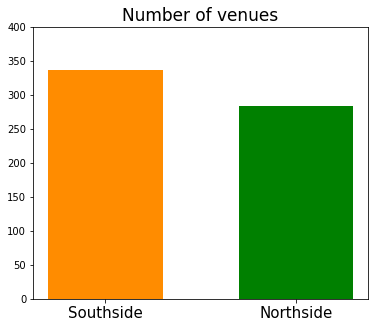

In [31]:
plt.figure(figsize=(6,5))
plt.bar(venuesSide['index'], venuesSide['Dublin side'],  color=['darkorange', 'green'], width=0.6)
plt.title('Number of venues', fontsize=17)
plt.ylim([0, 400])
plt.tick_params(axis='x', labelsize=15)

plt.show()

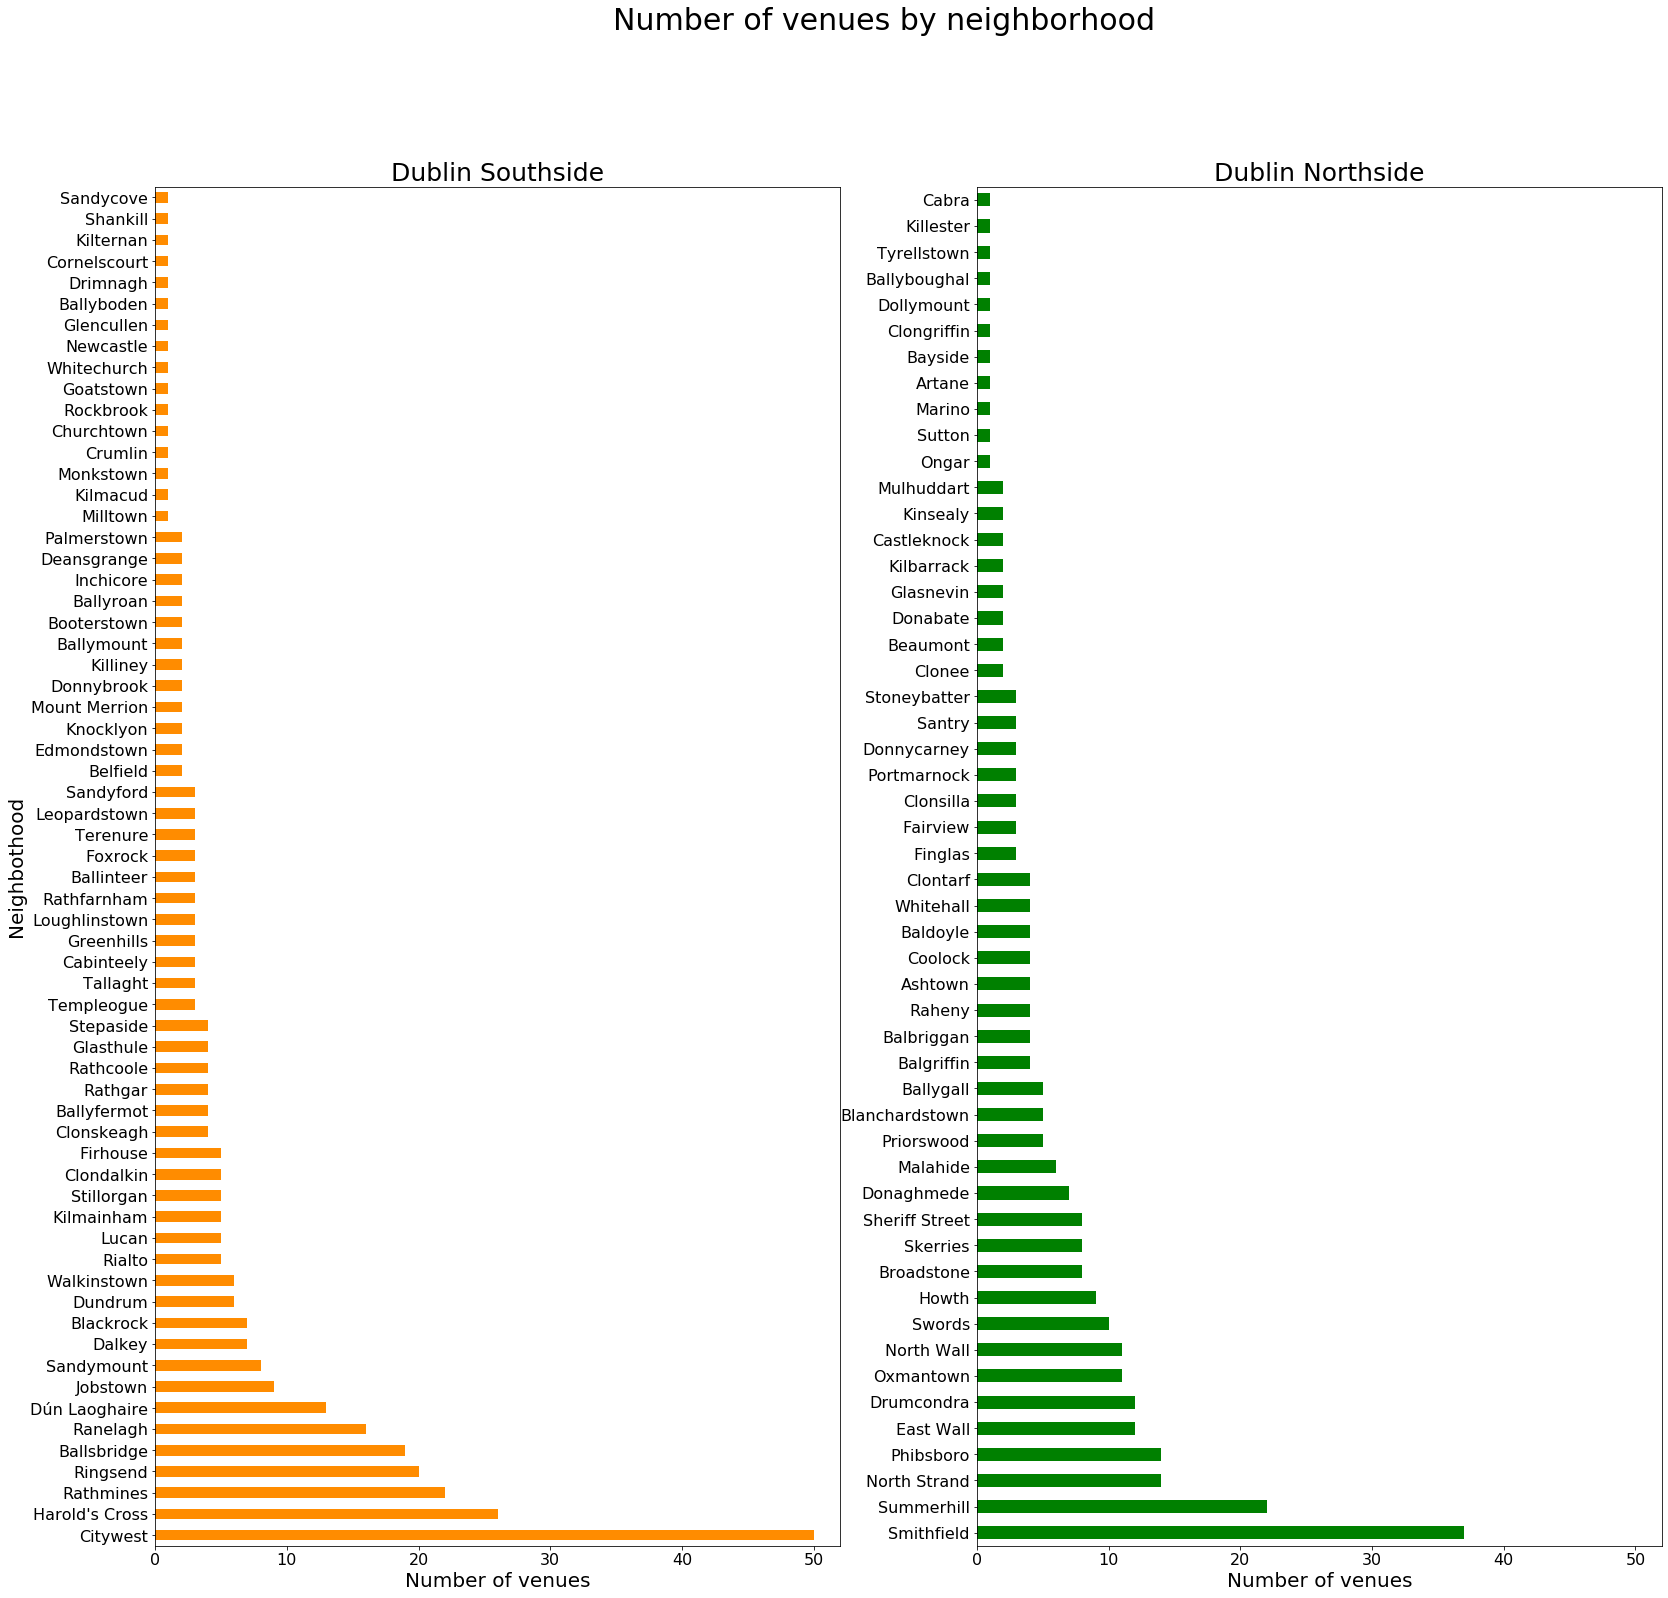

In [32]:
fig = plt.figure()
fig.suptitle('Number of venues by neighborhood', fontsize=30)

ax0 = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2)

southVenues = dfVenuesNeighborhood.loc[dfVenuesNeighborhood['Dublin side'] == 'Southside']['Neighborhood'].value_counts()

southVenues.to_frame().plot(kind='barh', figsize=(27, 25) ,ax=ax0, legend=None, color='darkorange')
ax0.set_title('Dublin Southside', fontsize=25)
ax0.set_xlabel('Number of venues', fontsize=20)
ax0.tick_params(axis='both', labelsize=16)
ax0.set_xlim([0, 52])
ax0.set_ylabel('Neighbothood', fontsize=20)

northVenues = dfVenuesNeighborhood.loc[dfVenuesNeighborhood['Dublin side'] == 'Northside']['Neighborhood'].value_counts()

northVenues.to_frame().plot(kind='barh',figsize=(27, 25), ax=ax1, legend=None, color='green')
ax1.set_title('Dublin Northside', fontsize=25)
ax1.set_xlabel('Number of venues', fontsize=20)
ax1.tick_params(axis='both', labelsize=16)
ax1.set_xlim([0, 52])

plt.show()

----------------

## Number of venue by categorie

In [33]:
numberVenues = dfVenuesNeighborhood['Categorie'].value_counts().to_frame()
numberVenues

,Categorie
Pub,308
Bar,133
Gastropub,28
Hotel Bar,23
Cocktail Bar,14
Restaurant,13
Wine Bar,11
Nightclub,10
Brewery,10
Lounge,9


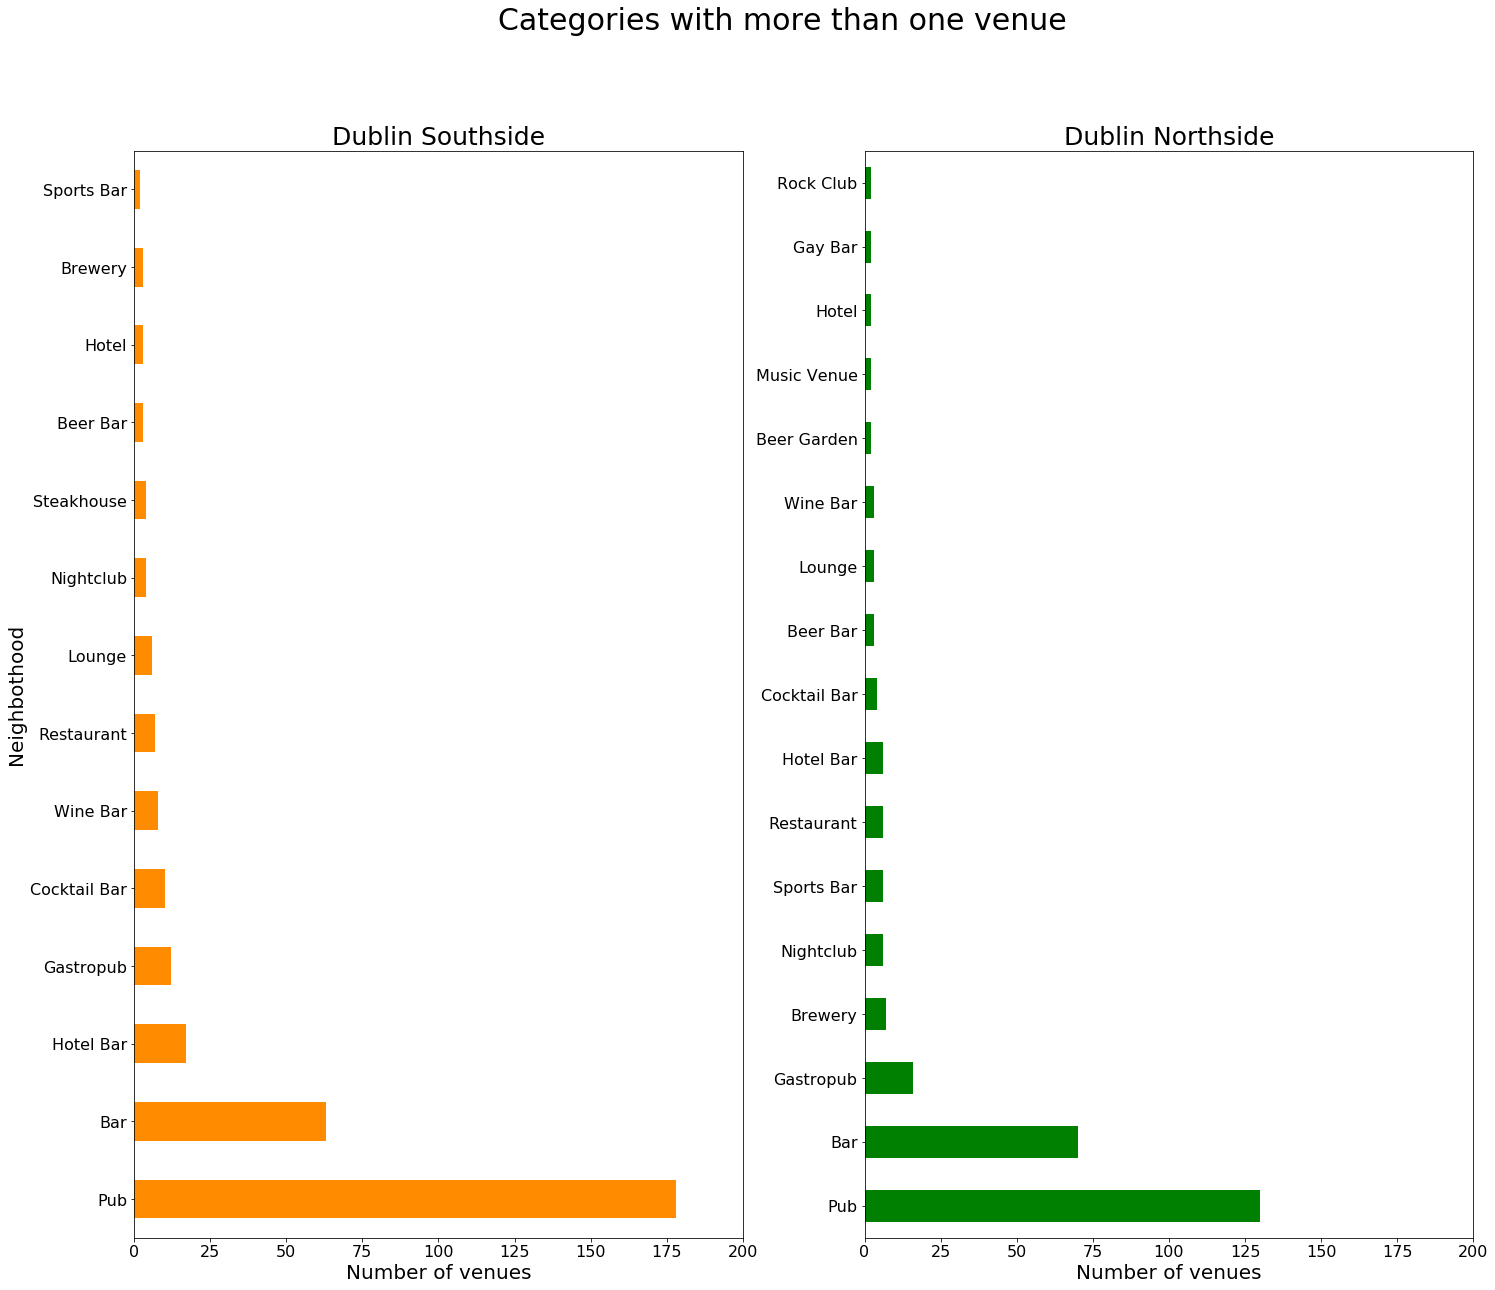

In [34]:
fig = plt.figure()
fig.suptitle('Categories with more than one venue', fontsize=30)

ax0 = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2)


southCategorie = dfVenuesNeighborhood.loc[dfVenuesNeighborhood['Dublin side'] == 'Southside']['Categorie'].value_counts()
southCategorie = southCategorie.to_frame()
southCategorie = southCategorie.loc[southCategorie['Categorie'] > 1]

southCategorie.plot(kind='barh', figsize=(24, 20) ,ax=ax0, legend=None, color='darkorange')
ax0.set_title('Dublin Southside', fontsize=25)
ax0.set_xlabel('Number of venues', fontsize=20)
ax0.tick_params(axis='both', labelsize=16)
ax0.set_xlim([0, 200])
ax0.set_ylabel('Neighbothood', fontsize=20)


northCategorie = dfVenuesNeighborhood.loc[dfVenuesNeighborhood['Dublin side'] == 'Northside']['Categorie'].value_counts()
northCategorie = northCategorie.to_frame()
northCategorie = northCategorie.loc[northCategorie['Categorie'] > 1]

northCategorie.plot(kind='barh',figsize=(24, 20), ax=ax1, legend=None, color='green')
ax1.set_title('Dublin Northside', fontsize=25)
ax1.set_xlabel('Number of venues', fontsize=20)
ax1.tick_params(axis='both', labelsize=16)
ax1.set_xlim([0, 200])

plt.show()

# K-means Model

## Preparing data

In [35]:
dfDummi = pd.get_dummies(dfVenuesNeighborhood[['Categorie']])
dfDummi.insert(0, 'Neighborhood', dfVenuesNeighborhood['Neighborhood'])

In [36]:
dfDummi.loc[dfDummi['Categorie_Bar'] > 0].head()

,Neighborhood,Categorie_Arcade,Categorie_Bar,Categorie_Beer Bar,Categorie_Beer Garden,Categorie_Brewery,Categorie_Café,Categorie_Cheese Shop,Categorie_Chinese Restaurant,Categorie_Cocktail Bar,...,Categorie_Rock Club,Categorie_Seafood Restaurant,Categorie_Speakeasy,Categorie_Sports Bar,Categorie_Steakhouse,Categorie_Tapas Restaurant,Categorie_Thai Restaurant,Categorie_Theater,Categorie_Whisky Bar,Categorie_Wine Bar
8,Ashtown,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,Balbriggan,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,Balbriggan,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,Balbriggan,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
35,Ballyboughal,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
dfGrouped = dfDummi.groupby('Neighborhood').sum()

In [38]:
dfGrouped.head()

,Categorie_Arcade,Categorie_Bar,Categorie_Beer Bar,Categorie_Beer Garden,Categorie_Brewery,Categorie_Café,Categorie_Cheese Shop,Categorie_Chinese Restaurant,Categorie_Cocktail Bar,Categorie_Coffee Shop,...,Categorie_Rock Club,Categorie_Seafood Restaurant,Categorie_Speakeasy,Categorie_Sports Bar,Categorie_Steakhouse,Categorie_Tapas Restaurant,Categorie_Thai Restaurant,Categorie_Theater,Categorie_Whisky Bar,Categorie_Wine Bar
Neighborhood,,,,,,,,,,,,,,,,,,,,,
Artane,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Ashtown,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Balbriggan,0,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Baldoyle,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Balgriffin,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
from sklearn.preprocessing import StandardScaler

X = dfGrouped.values[:,0:]
X = np.nan_to_num(X)
Clus_dataSet = StandardScaler().fit_transform(X)

In [40]:
Clus_dataSet[:1]

array([[-0.09325048, -0.7929742 , -0.20089486, -0.16293763, -0.25615776,
        -0.09325048, -0.09325048, -0.13245324, -0.19527492, -0.09325048,
        -0.09325048, -0.09325048, -0.09325048, -0.45090964, -0.13245324,
        -0.09325048, -0.09325048, -0.21223818, -0.40043929, -0.09325048,
        -0.09325048, -0.09325048, -0.09325048, -0.09325048, -0.26035058,
        -0.09325048, -0.16293763, -0.30714756, -0.09325048, -0.09325048,
        -0.47237368, -0.28817821, -0.13245324, -0.13245324, -0.09325048,
        -0.24164884, -0.21223818, -0.09325048, -0.09325048, -0.09325048,
        -0.13245324, -0.24101721]])

# The Elbow test

In [41]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(init='k-means++', n_clusters=k, n_init=50).fit(X)
    distortions.append(kmeanModel.inertia_)

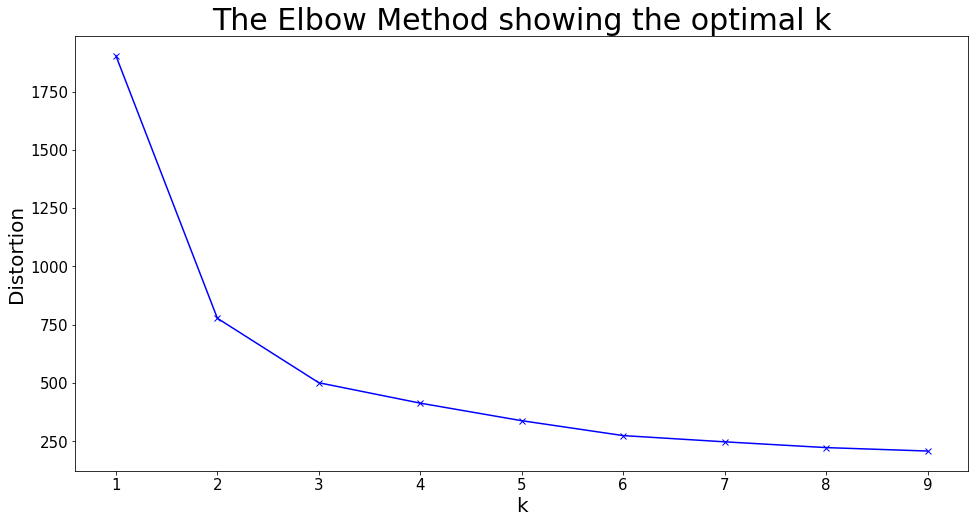

In [42]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k', fontsize=20)
plt.ylabel('Distortion', fontsize=20)
plt.title('The Elbow Method showing the optimal k', fontsize=30)
plt.tick_params(axis='both', labelsize=15)
plt.show()

## K-Means model with k=3

In [43]:
kclusters = 3

kmeans = KMeans(init='k-means++', n_clusters=kclusters, n_init=50).fit(X)

kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

In [44]:
dfGrouped.insert(0, 'Cluster', kmeans.labels_)

In [45]:
dfMerge = df.merge(dfGrouped['Cluster'], on='Neighborhood')

## Plotting clusters with folium 

In [46]:
ma_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

colors = ['darkorange', 'black', 'green']


for lat, lon, poi, cluster in zip(dfMerge['Latitude'], dfMerge['Longitude'], dfMerge['Neighborhood'], dfMerge['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=colors[cluster],
        fill=True,
        fill_color=colors[cluster],
        fill_opacity=0.7).add_to(ma_clusters)
       
ma_clusters

## Averaging venues by neighborhood

In [47]:
dfCluster = dfGrouped.groupby('Cluster').mean()
dfCluster.columns = dfCluster.columns.str.replace('Categorie_', '')

In [48]:
dfCluster

,Arcade,Bar,Beer Bar,Beer Garden,Brewery,Café,Cheese Shop,Chinese Restaurant,Cocktail Bar,Coffee Shop,...,Rock Club,Seafood Restaurant,Speakeasy,Sports Bar,Steakhouse,Tapas Restaurant,Thai Restaurant,Theater,Whisky Bar,Wine Bar
Cluster,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.702381,0.011905,0.023810,0.059524,0.011905,0.000000,0.011905,0.011905,0.000000,...,0.011905,0.000000,0.000000,0.035714,0.023810,0.000000,0.000000,0.000000,0.000000,0.035714
1,0.166667,3.833333,0.500000,0.000000,0.500000,0.000000,0.166667,0.166667,1.666667,0.166667,...,0.166667,0.000000,0.166667,0.333333,0.166667,0.166667,0.166667,0.166667,0.333333,1.000000
2,0.000000,1.961538,0.076923,0.038462,0.076923,0.000000,0.000000,0.000000,0.115385,0.000000,...,0.000000,0.076923,0.000000,0.115385,0.076923,0.000000,0.000000,0.000000,0.000000,0.076923


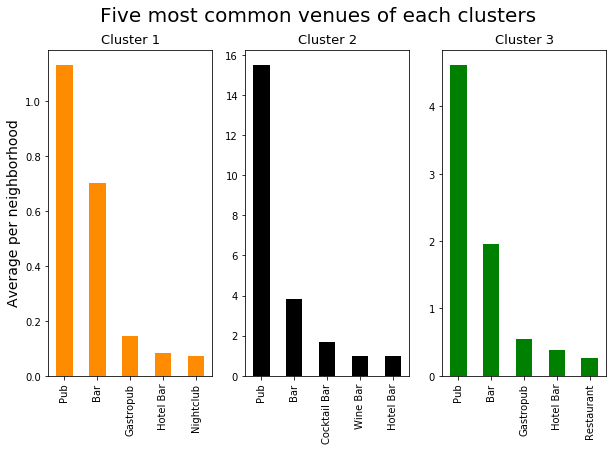

In [49]:
fig = plt.figure()
fig.suptitle('Five most common venues of each clusters', fontsize=20)

ax0 = fig.add_subplot(1, 3, 1)
ax1 = fig.add_subplot(1, 3, 2)
ax2 = fig.add_subplot(1, 3, 3)
figsize=(10,6)


cluster1 = dfCluster.loc[dfCluster.index == 0]
cluster1 = cluster1.transpose().sort_values(0, ascending=False)
cluster1[:5].plot(kind='bar', figsize=figsize, ax=ax0, legend=None, color='darkorange')
ax0.set_title('Cluster 1', fontsize=13)
ax0.set_ylabel('Average per neighborhood', fontsize=14)
# ax0.set_ylim([0, 0.6])

cluster2 = dfCluster.loc[dfCluster.index == 1]
cluster2 = cluster2.transpose().sort_values(1, ascending=False)
cluster2[:5].plot(kind='bar', figsize=figsize, ax=ax1, legend=None, color='black')
ax1.set_title('Cluster 2', fontsize=13)
# ax1.set_ylim([0, 0.6])

cluster3 = dfCluster.loc[dfCluster.index == 2]
cluster3 = cluster3.transpose().sort_values(2, ascending=False)
cluster3[:5].plot(kind='bar',figsize=figsize, ax=ax2, legend=None, color='green')
ax2.set_title('Cluster 3', fontsize=13)
# ax2.set_ylim([0, 0.6])

plt.show()